In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('wrds_out_index.csv.gz')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

def cheapo_float(s):
    try:
        return float(s)
    except:
        return np.nan
df['RET'] = df['RET'].map(cheapo_float)
#df = df.dropna(how='any')
df['logret'] = np.log(1+df['RET'])
df['RETdelta'] = df['RET']-df['sprtrn']
df['logretdelta'] = np.log(1+df['RETdelta'])
df['market_cap'] = df['SHROUT'] * df['PRC']
df['turnover_frac'] = df['VOL'] / df['SHROUT']
df['turnover_dollar'] = df['VOL'] * df['PRC']
df[:3]

C:\Users\dc38643\Miniconda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,PERMNO,TICKER,PRC,VOL,RET,SHROUT,sprtrn,logret,RETdelta,logretdelta,market_cap,turnover_frac,turnover_dollar
date,,,,,,,,,,,,,
2019-01-31,10026,JJSF,154.35001,21310.0,0.067501,18783.0,0.078684,0.065320,-0.011183,-0.011246,2.899156e+06,1.134537,3.289199e+06
2019-01-31,14187,DBEU,26.72000,72011.0,0.061581,30250.0,0.078684,0.059759,-0.017103,-0.017251,8.082800e+05,2.380529,1.924134e+06
2019-01-31,90762,LOR,9.56000,4142.0,0.128872,6880.0,0.078684,0.121219,0.050188,0.048969,6.577280e+04,0.602035,3.959752e+04


In [3]:
def do_one_step(df, start=0, window=6, bins=20):
    all_months = list(sorted(df.index.unique()))
    if start<0 or start+window+1>=len(all_months):
        return None
    
    df_train = df.loc[all_months[start:start+window]]
    df_test = df.loc[all_months[start+window+1]]
    
    binning_col = 'voldelta'
#     z = df_train.groupby(['PERMNO', 'TICKER'])['market_cap'].agg(lambda s: s.iloc[0])
    z = df_train.groupby(['PERMNO', 'TICKER'])['RETdelta'].std()
    
    z = z.rename(binning_col).reset_index().sort_values(by=binning_col, ascending=False)
    
    #z = z[z['market_cap']>0] # CHECK
    z['bin'], boundaries = pd.qcut(z[binning_col], bins, labels=np.arange(bins), retbins=True)
    #print(boundaries)
    df_train_joined = df_train.reset_index().merge(z[['PERMNO', 'bin']], left_on='PERMNO', right_on='PERMNO')
    
    ## long only
    long_or_short_sign = 2*(df_train_joined.groupby('bin')['RET'].mean() > 0).astype(int)-1
    train_returns = df_train_joined.groupby('bin')['RET'].mean().sort_index() * long_or_short_sign
    
    df_test_joined = df_test.reset_index().merge(z[['PERMNO', 'bin']], left_on='PERMNO', right_on='PERMNO')
    
    test_returns = df_test_joined.groupby('bin')['RET'].mean().sort_index() * long_or_short_sign
    return train_returns, test_returns

In [4]:
train_returns, test_returns = [], []
window, bins = 6, 10
for i in range(50):
    res = do_one_step(df, i, window=window, bins=bins)
    if res is not None:
        train_returns.append(res[0])
        test_returns.append(res[1])

#train_returns = pd.concat(train_returns, axis=1).T.reset_index().drop('index', axis=1)
#test_returns = pd.concat(test_returns, axis=1).T.reset_index().drop('index', axis=1)

train_returns = np.vstack(train_returns) # timesteps * #bins
test_returns = np.vstack(test_returns)

<Axes: >

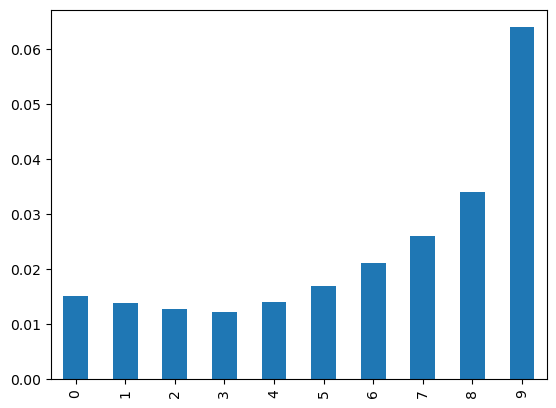

In [5]:
Series(np.mean(train_returns, axis=0)).plot(kind='bar')

In [6]:
Sigma = np.cov(train_returns.T)
B = Sigma[[-1,0]][:,[-1,0]]
B

array([[0.00410742, 0.0004636 ],
       [0.0004636 , 0.00012085]])

In [7]:
thisD = np.diag(np.sqrt(1/np.diagonal(B)))
thisD @ B @ thisD

array([[1.        , 0.65800997],
       [0.65800997, 1.        ]])

Text(0, 0.5, 'Average monthly return $\\mu(\\theta)$\n(shorting if needed)')

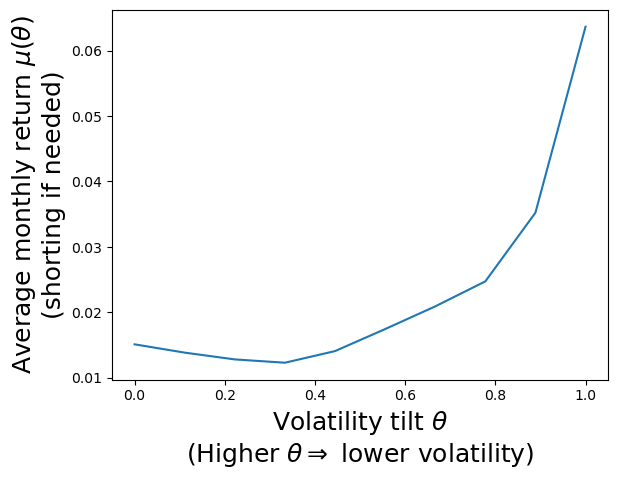

In [8]:
from scipy.interpolate import CubicSpline, BSpline
import cvxpy as cp

y = np.mean(train_returns, axis=0)
x = np.linspace(0,1,len(y))
all_x = np.linspace(0,1,100)

k, num_c = 3, 15
t = np.linspace(0, 1, num_c)
b_spline = BSpline(t, np.eye(num_c), k)

coeffs = cp.Variable(num_c)
objective = cp.sum_squares(b_spline(x) @ coeffs - y)
constraints = [b_spline(all_x, 2) @ coeffs >= 0]
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()
spl = BSpline(t, coeffs.value, k)

fontsize = 18
#plt.plot(x, y, label='Actual')
plt.plot(x, spl(x), label='Spline')
plt.xlabel(r'Volatility tilt $\theta$' +'\n' + r'(Higher $\theta\Rightarrow$ lower volatility)', fontsize=fontsize)
plt.ylabel(r'Average monthly return $\mu(\theta)$' + '\n' + r'(shorting if needed)', fontsize=fontsize)
#plt.legend()
# fig = plt.gcf()
# fig.savefig('figs/wrds_vol_mu.png', bbox_inches='tight')
# plt.legend()

In [9]:
from scipy.linalg import solve_sylvester

def get_T(t):
    return np.vstack([t, 1-t]).T

def get_t(tval, n=10, m=5):
    t = np.zeros(n)
    t[:m] = 1
    t[m] = tval
    return t

def get_M(mu):
    ones = np.ones(len(mu))
    M = np.outer(mu, ones)
    return M

def get_W(M, Sigma):
    W = solve_sylvester(Sigma, Sigma, 0.5*(M+M.T))
    return W
def get_W_from_T(T, rho, **kwds):
    mu = get_mu(T, **kwds)
    M = get_M(mu)
    Sigma = get_Sigma(T, rho=rho)
    W = get_W(M, Sigma)
    return W
def get_utilities(T, rho, **kwds):
    W = get_W_from_T(T, rho, **kwds)
    Sigma = get_Sigma(T, rho=rho)
    utilities = np.diag(W @ Sigma @ W)
    return utilities

def get_our_utils(n, f, train_returns, B=None, spline=None):
    m = int(n*f)

    y = np.mean(train_returns, axis=0)
    
    our_mu = np.zeros(n)
    if spline is None:
        our_mu[:m] = y[-1]
        our_mu[m+1:] = y[0]
    else:
        our_mu[:m] = spline(1)
        our_mu[m+1:] = spline(0)

    our_Sigma = np.zeros((n, n))
    our_Sigma[:m, :m] = Sigma[-1,-1]
    our_Sigma[:m, m+1:] = Sigma[0, -1]
    our_Sigma[m+1:, :m] = Sigma[0, -1]
    our_Sigma[m+1:, m+1:] = Sigma[0, 0]
    our_Sigma += 1e-2 * np.identity(n)

    utils = {}
    t_idx_arr = range(len(y)) if B is None or spline is None else np.linspace(0,100,100)
    for t_idx in t_idx_arr:
    #for t_idx in [15]:
        this_mu = our_mu.copy()
        if spline is None:
            this_mu[m] = y[t_idx]
        else:
            this_mu[m] = spline(t_idx / (len(t_idx_arr)-1))
        this_M = get_M(this_mu)

        this_Sigma = our_Sigma.copy()
        if B is None:
            this_Sigma[m, :m] = Sigma[-1, t_idx]
            this_Sigma[m, m] = Sigma[t_idx, t_idx]
            this_Sigma[m, m+1:] = Sigma[t_idx, 0]
            this_Sigma[:m, m] = this_Sigma[m,:m]
            this_Sigma[m+1:, m] = this_Sigma[m, m+1:]
        else:
#             t = np.zeros(n)
#             t[:m] = 1
#             t[m] = t_idx/(len(y)-1)
            this_T = get_T(get_t(tval=t_idx/(len(t_idx_arr)-1), n=n, m=m))
            this_Sigma = this_T @ B @ this_T.T + 0.1 * min(np.diagonal(B)) * np.identity(n)
            # print(this_Sigma[[0,m,-1]][:,[0,m,-1]])
            
    #     print(this_Sigma)

    #     tmp = (train_returns.shape[1]-1) * np.ones(n, dtype=int)
    #     tmp[m] = t_idx
    #     tmp[m+1:] = 0
    #     this_Sigma = np.cov(train_returns[:,tmp].T).reshape(n,n) #+ 1e-2 * np.identity(n)
    #     print(this_Sigma)
    #     print()

    #     print(this_Sigma, Sigma[t_idx, t_idx])

        W = get_W(this_M, this_Sigma)
        # print(W[[0,m,-1]][:,[0,m,-1]])
        utilities = np.diag(W.T @ (this_Sigma @ W))
        utils[t_idx/(len(t_idx_arr)-1)] = utilities[m]
    #     print(np.linalg.norm(W-W.T)/np.linalg.norm(W), utilities[m], W[m] @ (this_Sigma @ W[m]))

    return utils

    # Series(pred_utils).plot()
    #Series(y, index=np.arange(len(y))/len(y)).plot()

In [10]:
def util_one_firm(tval, mu_m, B):
    vec_t = np.array([tval, 1-tval]).T
    s = np.diagonal(vec_t @ B @ vec_t.T) + 0.1 * min(np.diagonal(B))
    # s = np.square(tval) + np.square(1-tval) + 2*rho*tval*(1-tval)
    return 1/4*np.square(mu_m)/s

In [11]:
fontsize, legend_fontsize = 18, 14
markers = ['s', 'o', 'v', 'p', '*']
colors = ['blue', 'red', 'black', 'cyan', 'magenta']

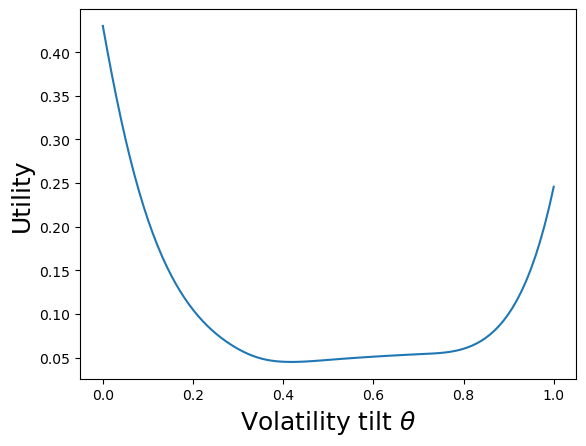

In [12]:
all_t = np.linspace(0,1,100)
one_firm_utils = util_one_firm(tval=all_t, mu_m=spl(all_t), B=B)
plt.plot(all_t, one_firm_utils)
plt.xlabel(r"Volatility tilt $\theta$", fontsize=fontsize)
plt.ylabel(r"Utility", fontsize=fontsize)
fig = plt.gcf()
#fig.savefig('figs/wrds_vol_one_firm.png', bbox_inches='tight')

In [13]:
n = 401
all_utils = {}
for f in [0.1, 0.3, 0.9]:
    utils = get_our_utils(n=n, f=f, train_returns=train_returns, B=B, spline=spl)
    all_utils[f] = utils

[None]

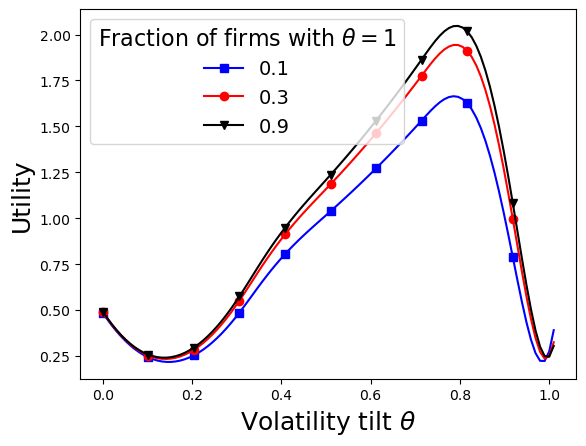

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for idx, f in enumerate(all_utils.keys()):
    utils = all_utils[f]
    Series(utils).plot(ax=ax, marker=markers[idx], color=colors[idx], markevery=10, label=f'{f}')
ax.set_xlabel(r"Volatility tilt $\theta$", fontsize=fontsize)
ax.set_ylabel(r"Utility", fontsize=fontsize)
legend=ax.legend(title=r'Fraction of firms with $\theta=1$', fontsize=legend_fontsize)
plt.setp(legend.get_title(),fontsize=16)
# fig.savefig('figs/wrds_vol_smooth.png', bbox_inches='tight')